<a href="https://colab.research.google.com/github/Finalmatt/pandorabox/blob/master/Bag_of_Words_StackOverflow_Tags_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os


def download_github_code(path):
    filename = path.rsplit("/")[-1]
    os.system("wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/{} -O {}".format(path, filename))


def setup_common():
    download_github_code("common/requirements_colab.txt")
    download_github_code("common/download_utils.py")
    download_github_code("common/tqdm_utils.py")
    download_github_code("common/__init__.py")
    os.system("mkdir common")
    os.system("mv download_utils.py tqdm_utils.py __init__.py common/")
    os.system("mv requirements_colab.txt common/")

    os.system("pip install -r common/requirements_colab.txt --force-reinstall")


def setup_starspace():
    if not os.path.exists("/usr/local/bin/starspace"):
        os.system("wget https://dl.bintray.com/boostorg/release/1.63.0/source/boost_1_63_0.zip")
        os.system("unzip boost_1_63_0.zip && mv boost_1_63_0 /usr/local/bin")
        os.system("git clone https://github.com/facebookresearch/Starspace.git")
        os.system("cd Starspace && make && cp -Rf starspace /usr/local/bin")


def setup_week1():
    setup_common()
    download_github_code("week1/grader.py")
    download_github_code("week1/metrics.py")


def setup_week2():
    setup_common()
    download_github_code("week2/evaluation.py")


def setup_week3():
    setup_common()
    download_github_code("week3/grader.py")
    download_github_code("week3/util.py")
    setup_starspace()


def setup_week4():
    setup_common()


def setup_project():
    setup_common()
    download_github_code("project/dialogue_manager.py")
    download_github_code("project/main_bot.py")
    download_github_code("project/utils.py")
    setup_starspace()


def setup_honor():
    setup_common()
    download_github_code("honor/datasets.py")
    download_github_code("honor/example.py")
    download_github_code("honor/download_cornell.sh")
    download_github_code("honor/download_opensubs.sh")

setup_week1()



In [0]:
from grader import Grader
grader = Grader()

In [170]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


In [171]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd
import numpy as np


import re






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data



In [0]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [174]:


train.head()



,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [0]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text =  REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = word_tokenize(text)
    text = text.split()
    text = [word for word in text if not word in STOPWORDS] # delete stopwords from text

    text = (" ").join(text)
    return text

In [0]:


def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:

            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'



In [178]:
print(test_text_prepare())

Basic tests are passed.


In [179]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [0]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [181]:
X_train[:3]
len(X_train)

100000

In [0]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

for title in X_train:
  title = title.split()
  for word in title:
    if word in words_counts:
      words_counts[word] += 1
    else:
      words_counts[word] = 1

'''for line in X_train:
  word_list = line.split()
  for word in word_list: 
    words_counts[word] = words_counts.get(word, 0) + 1'''


for tag_list in y_train:
  for tag in tag_list:
    if tag in tags_counts:
      tags_counts[tag] += 1
    else:
      tags_counts[tag] = 1



In [183]:


most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [184]:
len(words_counts)

31497

In [0]:
DICT_SIZE = 5000
WORDS_TO_INDEX = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000]
WORDS_TO_INDEX = { WORDS_TO_INDEX[i][0] : i for i in range(0, len(WORDS_TO_INDEX) ) }
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
      if word in words_to_index:
        result_vector[words_to_index[word]] = 1
    


    return result_vector

In [0]:


def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'



In [187]:
print(test_my_bag_of_words())

Basic tests are passed.


In [0]:
from scipy import sparse as sp_sparse

In [189]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)



X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [190]:
from collections import Counter
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range =(1,2), max_df=0.9, min_df= 5, token_pattern = '(\S+)')
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)

    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_



In [0]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [212]:


"c++" in tfidf_vocab.keys()
"c#" in tfidf_vocab.keys()

"c++" in tfidf_reversed_vocab.values()
"c#" in tfidf_reversed_vocab.values()


True

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [0]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    clf = OneVsRestClassifier(LogisticRegression( penalty = 'l2', C = 10, solver = 'newton-cg'))
    clf.fit(X_train,y_train)

    return clf


In [0]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [0]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [258]:


y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))



Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	c#


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [0]:
def print_evaluation_scores(y_val, predicted):
    
    print('Accuracy_score is '+ str(accuracy_score(y_val, predicted)))
    print('recall score is ' + str(recall_score(y_val, predicted,average="weighted")))
    print('F1 score is ' + str(f1_score(y_val, predicted,average="weighted")))
    #print('roc_auc score is ' + str(roc_auc_score(y_val, predicted)))
    #print('average_precision score is ' + str(average_precision_score(y_val, predicted)))


In [261]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy_score is 0.3530333333333333
recall score is 0.5773713895060674
F1 score is 0.6538745229174785
Tfidf
Accuracy_score is 0.36306666666666665
recall score is 0.5683985643479748
F1 score is 0.6540084535619047


In [0]:
from metrics import roc_auc
%matplotlib inline

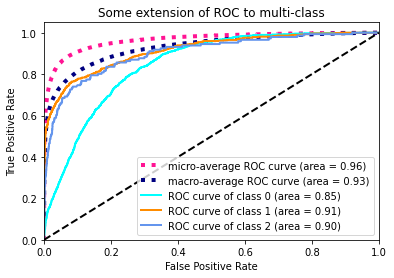

In [263]:


n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)



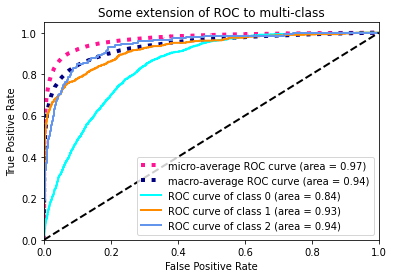

In [264]:


n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)



In [266]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json
...


In [0]:

def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    tag_estimator = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in tag_estimator.coef_.argsort().tolist()[0][-5:]]
    top_negative_words = [index_to_words[index] for index in tag_estimator.coef_.argsort().tolist()[0][:5]]

    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [291]:


print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)



Tag:	c
Top positive words:	printf, fscanf, scanf, malloc, c
Top negative words:	php, java, python, javascript, c#

Tag:	c++
Top positive words:	stdstring, mfc, boost, qt, c++
Top negative words:	java, php, javascript, python, c#

Tag:	linux
Top positive words:	dlopen, kernel space, system call, killed, linux
Top negative words:	javascript, c#, aspnet, codeigniter, nokogiri



You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json
...
